Markov state model for BPTI
=====

<pre> 
Antonia Mey                antonia.mey@fu-berlin.de  
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
Frank Noe                  frank.noe@fu-berlin.de    

adapted for PyEMMA 1.2.2
</pre>

First import the pyemma package and check if we have the right version number:

In [1]:
import pyemma
pyemma.__version__

'1.2.2'

This notebook has been tested for PyEMMA 1.2.2. If you have a later version, changes may be required.

Now we import a few general packages that we need to start with. The following imports basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import matplotlib.pylab as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now we import the pyEMMA package that we will be using in the beginning: the coordinates package. This package contains functions and classes for reading and writing trajectory files, extracting order parameters from them (such as distances or angles), as well as various methods for dimensionality reduction and clustering. 

The shortcuts module is a bunch of functions specific to this workshop - they help us to visualize some of our results. Some of them might become part of the pyemma package once they are more mature.

In [3]:
import pyemma.coordinates as coor
import shortcuts

BPTI 1 ms trajectory - load data
------

In this workshop we will be using the 1 millisecond trajectory of Bovine Pancreatic Trypsin Inhibitor (BPTI) generated by DE Shaw Research on the Anton Supercomputer [1]. In order to make the data size manageable we have saved only the Ca-coordinates and only every 10 ns, resulting in about 100000 frames.

First we define coordinate and topology input file by pointing to a local data directory. Note that instead of using a single trajectory file you could specify a list of many trajectory files here - the rest of the analysis stays the same.

In [4]:
trajfile = 'data_full/bpti_ca_1ms_dt10ns.xtc'
topfile = 'data_full/bpti_ca.pdb'

Now we decide which coordinates we would like to use in the further analysis. Since this trajectory is already RMSD-aligned we can simply use the Cartesian coordinates, here Ca-coordinates:

In [5]:
feat = coor.featurizer(topfile)
# just use all xyz-coordinates
feat.add_all()

We can ask the featurizer to tell describe the coordinates used - so we can later remember what we did. The return is a list of strings and we will just print the first few labels here:

In [6]:
feat.describe()[:10]

['ATOM:ARG 0 CA 0 x',
 'ATOM:ARG 0 CA 0 y',
 'ATOM:ARG 0 CA 0 z',
 'ATOM:PRO 1 CA 1 x',
 'ATOM:PRO 1 CA 1 y',
 'ATOM:PRO 1 CA 1 z',
 'ATOM:ASP 2 CA 2 x',
 'ATOM:ASP 2 CA 2 y',
 'ATOM:ASP 2 CA 2 z',
 'ATOM:PHE 3 CA 3 x']

Next we want to load the coordinates from disc. Often, coordinates will not fit into memory, so we'll just create a loader by specifying the source files as follows:

In [7]:
inp = coor.source(trajfile, feat)
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

trajectory length =  103125
number of dimension =  174


That's 174 coordinates for 58 Ca-atoms. In practice you will often be using more coordinates in the beginning, but we want to keep our example simple and fast.

time-lagged independent component analysis (TICA)
----------
In principle we could now directly go on to do data clustering. However, doing anything in 174 dimensions is quite inefficient. Not so much because of the CPU time needed, but rather because in such a high-dimensional space it is difficult to efficiently discretize data where it matters. So we would like to first reduce our dimension by throwing out the 'uninteresting' ones and only keeping the 'relevant' ones. But how do we do that?

It turns out that a really good way to do that if you are interesting in the slow kinetics of the molecule - e.g. for constructing a Markov model, is to use the time-lagged independent component analysis (TICA) [2]. Amongst linear methods, TICA is optimal in its ability to approximate the relevant slow coordinates / reaction coordinates from MD simulation [3], and therefore it's ideal to construct Markov models. Probably you are more familiar with the principal component analysis (PCA), but we will come back to that later...

In [8]:
lag=100
tica_obj = coor.tica(inp, lag=lag, dim=2)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
print 'Projected data shape = ',Y.shape

2015-07-22 16:03:58,468 coordinates.transform.TICA[1] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:03:58,469 coordinates.transform.TICA[1] INFO     Running TICA with tau=100; Estimating two covariance matrices with dimension (174, 174)


Projected data shape =  (103125, 2)


The TICA object has a number of properties that we can extract and work with. We have already obtained the projected trajectory and wrote it in a variable Y that is a matrix of size (103125 x 2). The rows are the MD steps, the 2 columns are the independent component coordinates projected onto. So each columns is a trajectory. Let us plot them:

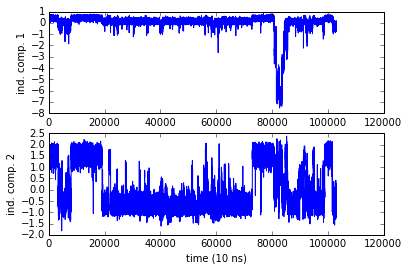

In [9]:
subplot2grid((2,1),(0,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y[:,1])
ylabel('ind. comp. 2')
xlabel('time (10 ns)')

Even in a 1 ms simulation we have a rare event in the first coordinate. Damn sampling problem. It looks like no trajectory can ever be long enough

A particular thing about the IC's is that they have zero mean and variance one. We can easily check that:

In [10]:
print 'Mean values: ',np.mean(Y, axis=0)
print 'Variances:   ',np.var(Y, axis=0)

Mean values:  [ -3.91613071e-07  -2.29790521e-06]
Variances:    [ 0.99997342  0.99997717]


The small deviations from 0 and 1 come from statistical and numerical issues. That's not a problem.

TICA is a special transformation because it will project the data such that the autocorrelation along the independent components is as slow as possible. The eigenvalues of the TICA transform are the values of these autocorrelations at the chosen lag time (here 100). We can even interpret them in terms of relaxation timescales:

In [11]:
print -lag/np.log(tica_obj.eigenvalues[:5])

[ 2160.63561814   944.11636399   651.18422373   374.30384994   306.15671421]


We will see more timescales later when we estimate a Markov model, and there will be some differences. For now you should treat these numbers as a rough guess of your molecule's timescales, and we will see later that this guess is actually a bit too fast. The timescales are relative to the 10 ns saving interval, so we have 21 microseconds, 9 microseconds, ..

Now we histogram this data and compute the apparent free energy landscape

/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x7f6dd53b63f8>

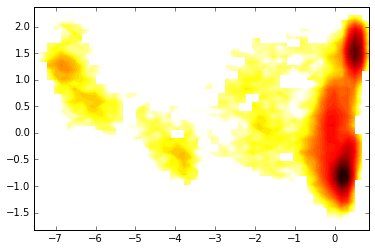

In [12]:
# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)

So we nicely see that there are a couple of different energy minima are present and clearly separated in the TICA projection.

Clustering the data
------

we use k-means clustering and get the discrete trajectories

In [13]:
cl = coor.cluster_kmeans(data=Y, k=100, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

2015-07-22 16:04:04,087 coordinates.clustering.KmeansClustering[2] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:04,947 coordinates.clustering.KmeansClustering[2] INFO     Accumulated all data, running kmeans on (103125, 2)
2015-07-22 16:04:05,704 coordinates.clustering.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


where are the clusters?

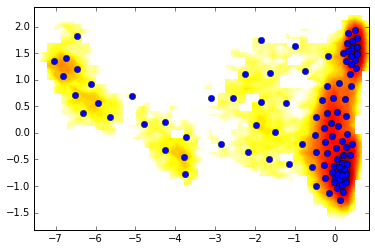

In [14]:
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o')

For our purpose, the main result from the clustering algorithm are discrete trajectories:

In [15]:
cl.dtrajs

[array([11, 64, 26, ...,  5,  5, 86], dtype=int32)]

This is a list of integer-arrays, one for each trajectory used (here only one). The integer-array contains one number between 0 and 99 (because we have used 100 cluster centers) for each MD trajectory frame.

Let's play
-----

Now let's play around a little bit. Please refer to the pyEMMA coordinates documentation at:

    http://www.pythonhosted.org/pyEMMA/api/index_corr.html

and try to vary the code above in the following ways:

1. Try different clustering methods, such as regspace and uniform time clustering instead of using k-means. Also try to change the parameters. What are the differences you observe? What do you think is the best strategy for clustering your data?
2. Instead of using TICA to project your high-dimensional data, try to use PCA. Discuss the differences in the projected trajectories and in the free energy plot. Which one do you think will be better to detect the slow conformational changes
3. In the approach above you have streamed everything from the file because we wanted to keep the memory requirements small. For example, when you did the k-means clustering, the data was read from the file, transformed through your TICA transformation, and then clustered. Our data is small enough that we could have loaded everything into memory. Try to do that using the load function, and pass the result directly into TICA instead of passing the source object (inp). Likewise, take the resulting data from TICA (Y), and pass it directly to k-means. What is different now?
4. For large data sets you can further speed things up by using strides. Play around with the stride parameter using in k-means and see what changes. You can use a stride at every step of your data processing pipeline
5. Play around with different coordinates. Instead of just looking at Ca-positions, try angles, distances etc. Look at the result when you load data. Try to push it - can you compute all pairwise distances and still load the data into memory?

1) Different clustering methods
-------

2015-07-22 16:04:06,018 coordinates.clustering.UniformTimeClustering[4] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:06,018 coordinates.clustering.UniformTimeClustering[4] INFO     Running uniform time clustering


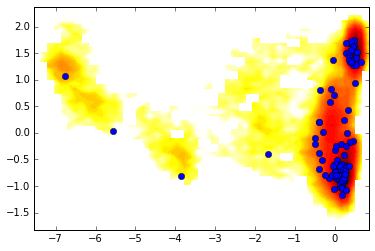

In [16]:
clu = coor.cluster_uniform_time(data=Y, k=100)
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(clu.clustercenters[:,0], clu.clustercenters[:,1], linewidth=0, marker='o')

2015-07-22 16:04:06,255 coordinates.clustering.RegularSpaceClustering[6] INFO     reset (previous) parametrization state, since data producer has been changed.


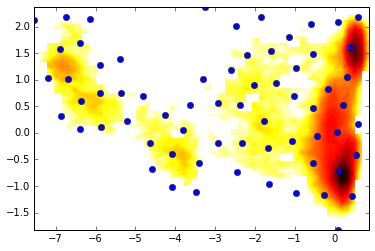

In [17]:
clr = coor.cluster_regspace(data=Y, dmin=0.5)
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(clr.clustercenters[:,0], clr.clustercenters[:,1], linewidth=0, marker='o')

2) PCA vs TICA
-------

2015-07-22 16:04:06,513 coordinates.transform.PCA[8] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:06,514 coordinates.transform.PCA[8] INFO     Running PCA on 174 dimensional input


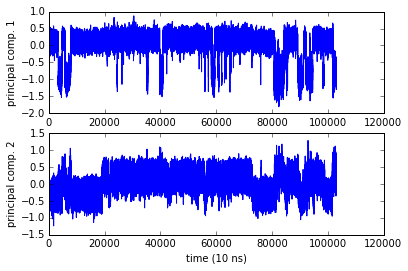

In [18]:
pca_obj = coor.pca(inp, dim=2)
Ypca = pca_obj.get_output()[0]
subplot2grid((2,1),(0,0))
plot(Ypca[:,0])
ylabel('principal comp. 1')
subplot2grid((2,1),(1,0))
plot(Ypca[:,1])
ylabel('principal comp. 2')
xlabel('time (10 ns)')

/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x7f6dd471d1b8>

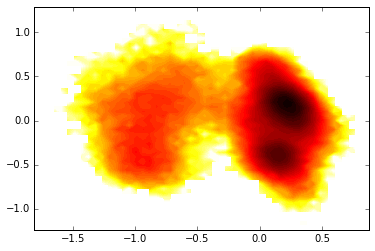

In [19]:
# histogram data
z_,x_,y_ = np.histogram2d(Ypca[:,0],Ypca[:,1], bins=50)
# compute free energies
F_ = -np.log(z_)
# contour plot
extent_ = [x_[0], x_[-1], y_[0], y_[-1]]
contourf(F_.T, 50, cmap=plt.cm.hot, extent=extent_)

3) Do everything in memory
------

2015-07-22 16:04:11,756 coordinates.transform.TICA[10] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:11,756 coordinates.transform.TICA[10] INFO     Running TICA with tau=100; Estimating two covariance matrices with dimension (174, 174)
2015-07-22 16:04:12,968 coordinates.clustering.KmeansClustering[12] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:13,898 coordinates.clustering.KmeansClustering[12] INFO     Accumulated all data, running kmeans on (103125, 2)
2015-07-22 16:04:14,659 coordinates.clustering.KmeansClustering[12] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


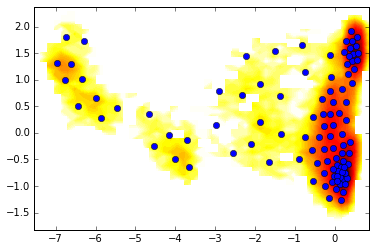

In [20]:
X = coor.load(trajfile, feat)
Y1 = coor.tica(X, lag=lag, dim=2).get_output()
km = coor.cluster_kmeans(Y1, k=100)
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
# sign of -km.clustercenters[:,0] is changed here to be correct in the plot.
# the direction may change due to a random initialization of the eigenvectors.
plot(-km.clustercenters[:,0],km.clustercenters[:,1], linewidth=0, marker='o')

4) Do everything as a pipeline
-------

2015-07-22 16:04:14,906 coordinates.transform.TICA[15] INFO     Running TICA with tau=100; Estimating two covariance matrices with dimension (174, 174)
2015-07-22 16:04:20,696 coordinates.clustering.KmeansClustering[16] INFO     Accumulated all data, running kmeans on (103125, 2)
2015-07-22 16:04:21,414 coordinates.clustering.KmeansClustering[16] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


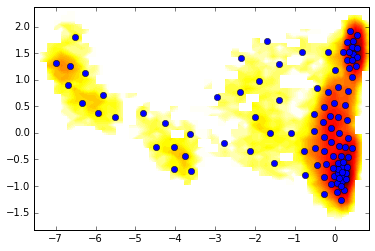

In [21]:
stage1 = coor.source(trajfile, feat)
stage2 = coor.tica(lag=lag, dim=2)
stage3 = coor.cluster_kmeans(k=100)
coor.pipeline([stage1,stage2,stage3])
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plot(stage3.clustercenters[:,0],stage3.clustercenters[:,1], linewidth=0, marker='o')

5) Striding
-------

In [22]:
%time coor.cluster_kmeans(data=Y, k=100, stride=1)

2015-07-22 16:04:21,626 coordinates.clustering.KmeansClustering[17] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:22,508 coordinates.clustering.KmeansClustering[17] INFO     Accumulated all data, running kmeans on (103125, 2)
2015-07-22 16:04:23,241 coordinates.clustering.KmeansClustering[17] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s
Wall time: 1.62 s


In [23]:
%time coor.cluster_kmeans(data=Y, k=100, stride=10)

2015-07-22 16:04:23,252 coordinates.clustering.KmeansClustering[19] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:23,384 coordinates.clustering.KmeansClustering[19] INFO     Accumulated all data, running kmeans on (10313, 2)
2015-07-22 16:04:23,472 coordinates.clustering.KmeansClustering[19] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


CPU times: user 220 ms, sys: 4 ms, total: 224 ms
Wall time: 221 ms


6) Different coordinates
-------

2015-07-22 16:04:23,502 coordinates.transform.TICA[22] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:04:23,512 coordinates.transform.TICA[22] INFO     Running TICA with tau=100; Estimating two covariance matrices with dimension (1540, 1540)


number of dimension =  1540


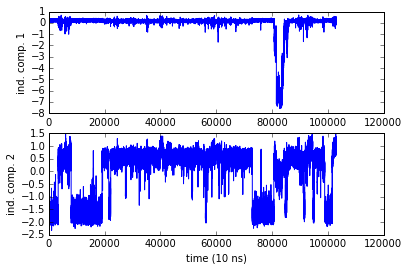

In [24]:
feat2 = coor.featurizer(topfile)
feat2.add_distances_ca(periodic=False)
inp_ = coor.source(trajfile, feat2)
print 'number of dimension = ',inp_.dimension()
tica_obj_ = coor.tica(inp_, lag=lag, dim=2)
# plot
Y_ = tica_obj_.get_output()[0]
subplot2grid((2,1),(0,0))
plot(Y_[:,0])
ylabel('ind. comp. 1')
subplot2grid((2,1),(1,0))
plot(Y_[:,1])
ylabel('ind. comp. 2')
xlabel('time (10 ns)')

2015-07-22 16:06:52,981 coordinates.clustering.KmeansClustering[23] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-22 16:06:53,863 coordinates.clustering.KmeansClustering[23] INFO     Accumulated all data, running kmeans on (103125, 2)
2015-07-22 16:06:54,584 coordinates.clustering.KmeansClustering[23] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.
/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


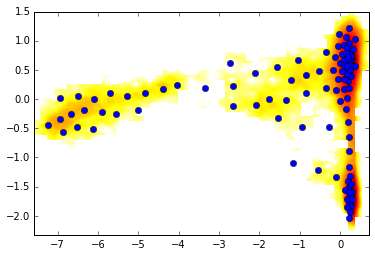

In [25]:
# cluster
km = coor.cluster_kmeans(Y_, k=100)
# histogram data
z_,x_,y_ = np.histogram2d(Y_[:,0],Y_[:,1], bins=50)
# compute free energies
F_ = -np.log(z_)
# contour plot
extent_ = [x_[0], x_[-1], y_[0], y_[-1]]
# plot
contourf(F_.T, 50, cmap=plt.cm.hot, extent=extent_)
plot(km.clustercenters[:,0],km.clustercenters[:,1], linewidth=0, marker='o')

MSM estimation
---------
In this chapter we want to estimate a Markov model, and then analyze it. First we import the msm package from pyemma, and then we also import a plotting package which offers a few standard ways for visualizing data.

In [26]:
import pyemma.msm as msm
import pyemma.plots as mpl

The quality and the practical usefulness of a Markov model depend on two main parameters:

1. The state-space discretization, i.e. which steps we have conducted before (choice of coordinates, projection method, clustering method)
2. The lag time, i.e. at which time do we count transitions.

The first choice is quite complex and there are some ways to deal with this complexity and the reduce the number of choices, although we won't discuss them in detail here. The second parameter is extremely important, and we should scan it in order to make a good selection. So Let us compute the so-called implied timescales, or relaxation timescales of the Markov model at different lag times:

In [27]:
lags = [1,2,5,10,20,50,100,200]
its = msm.its(dtrajs, lags=lags)

What this function does is to estimate a Markov model at each of the given lag times $\tau$ (that are multiples of our saving step, i.e. multiples of 10 ns), compute the eigenvalues of each transition matrix, $\lambda_i(\tau)$, and then compute the relaxation timescales by:
   $$ t_i = \frac{-\tau}{\ln | \lambda_i(\tau) |}$$
The its object will mainly give us these estimated timescales. We can simply push the result to a standard plotting function:

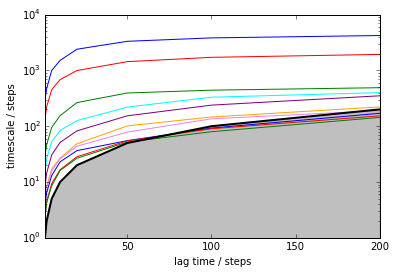

In [28]:
mpl.plot_implied_timescales(its)

It has been shown [4] that these timescales should be independent of the lag time. You can see that for short lag times they are not, but after about 100 steps (1 microsecond), they are pretty constant. The faster timescales still increase. Part of this is normal and due to numerical issues. Part of this is because our state space discretization is rather naive - we cannot hope to capture a lot of relaxation processes when using only two dimensions.

In a nutshell: longer timescale is better, at least as long you stay away from the grey area. The grey area is defined by lag > timescale, and in this area we cannot make a reliable estimate because the process under investigation has already decayed. Everything within or close to the grey area is distorted.

Of course looking at a plot and judging the flatness by eye is not really sophisticated. Especially because the error bars on these timescales can be pretty big. Let's compute some errors using bootstrapping and plot again...

In [29]:
its.bootstrap(nsample=20)

(0, 200)

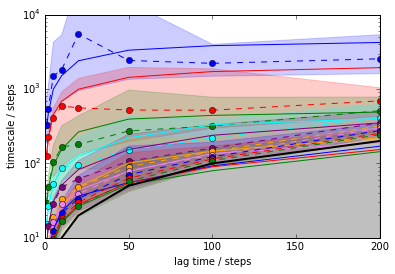

In [30]:
mpl.plot_implied_timescales(its)
ylim(10,10000)
xlim(0,200)

So you see that to be constant within the error bars, we could even use shorter lag times. But let's go with 100 for now. You will also see that the error bars don't really match the maximum likelihood estimates for long lag times. That's because we tend to loose connectivity in this scenario. Good error estimates for reversible MSMs are difficult! Anyway, the next pyEMMA version (1.3) will have a much better error handling and no longer display this problem.

MSM
---
So finally we can estimate a Markov model. In fact we have already estimated a several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering and the lag time:

In [31]:
M = msm.estimate_markov_model(dtrajs, 100)

The Markov model will be constructed on the largest connected set of states. That could mean that we exclude some states from the analysis. Let us verify that this is not the case here:

In [32]:
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

(-0.5, 10.5)

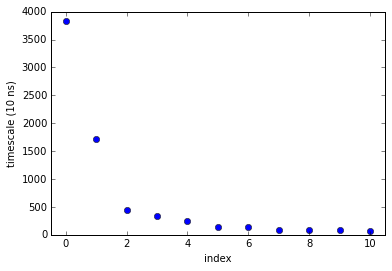

In [33]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (10 ns)'); xlim(-0.5,10.5)

We can also look at that data by taking the ratios of subsequent timescales. This shows us how big the gap of timescales (or rates) are.

(-0.5, 10.5)

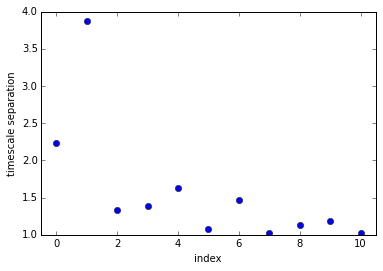

In [34]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

It can be seen that there is a large timescale separation between the second and third relaxation timescale. That means that if we are interested in coarse-graining our dynamics, retaining two relaxation timescales, or three metastable states, is a good choice.

Now let us look at the second (slowest) right eigenvector

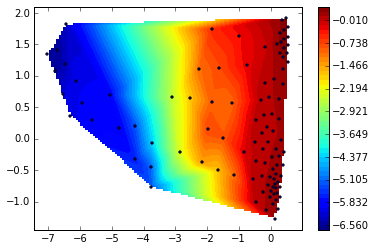

In [35]:
r2 = M.eigenvectors_right()[:,1]
ax = mpl.scatter_contour(cc_x, cc_y, r2)

Clearly, the slowest process (about 40 microseconds) involves a change along the first TICA component. This is great news for TICA, because it means that even before computing a Markov model we have done a very good job in finding a slow order parameter. However, remember that this process has occurred only once in the trajectory, so unfortunatly our data is quite poor with respect to quantifying it.

Let us then look at the third (next-slowest) right eigenvector

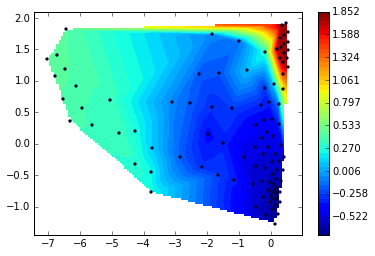

In [36]:
r3 = M.eigenvectors_right()[:,2]
mpl.scatter_contour(cc_x, cc_y, r3)

This process is between 15 and 20 microseconds and clearly transitions between the two prominent minima on the left.

Now we want to coarse-grain our system to get a simpler description. The PCCA method [5] uses the eigenvectors in order to perform a spectral clustering. This clustering is fuzzy, i.e. each of our k-means clusters is linked to one of the metastable states with a certain probability or membership. Here we plot the Bayesian inverse, i.e. the probability to be in a small state given that we are in a metastable state. We choose three metastable states, so we have three distributions:

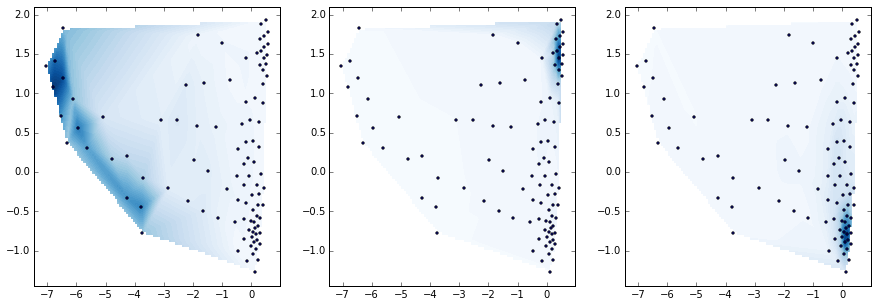

In [37]:
M.pcca(3)
pcca_dist = M.metastable_distributions
f, (ax1,ax2,ax3) = subplots(ncols=3)
f.set_size_inches(15,5)
cmap=plt.cm.Blues
mpl.scatter_contour(cc_x, cc_y, pcca_dist[0], fig=f, ax=ax1, colorbar=False, cmap=cmap)
mpl.scatter_contour(cc_x, cc_y, pcca_dist[1], fig=f, ax=ax2, colorbar=False, cmap=cmap)
mpl.scatter_contour(cc_x, cc_y, pcca_dist[2], fig=f, ax=ax3, colorbar=False, cmap=cmap)

MSM trajectory
-------

Let's generate a synthetic MSM trajectory (100 milliseconds). This is just for playing around
There's nothing you can compute from this trajectory that you couldn't do better with a 
direct matrix analysis, but for some reason people seem to love it...

In [38]:
index_traj = M.generate_traj(100000)

let's just read out the x/y coordinates of our cluster centers using the synthetic trajectory

In [39]:
I = index_traj[:,1]
dtraj_synthetic = M.discrete_trajectories_full[0][I]
x_synthetic = cl.clustercenters[dtraj_synthetic,0]
y_synthetic = cl.clustercenters[dtraj_synthetic,1]

Plot them. You can see the rare excursions to the low-populated state happening 
about 6 times in the first 10 ms.
The next process is much more frequent. 

(0, 10000)

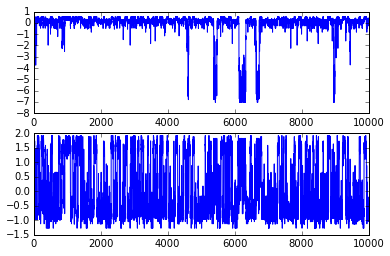

In [40]:
subplot2grid((2,1),(0,0))
plot(x_synthetic)
xlim(0,10000)
subplot2grid((2,1),(1,0))
plot(y_synthetic)
xlim(0,10000)

Representative Structures
--------

Now we want to see some structures. Let us use the PCCA distributions in order to select structures.
We will get 100 frame indexes for each of the three distributions

In [41]:
pcca_samples = M.sample_by_distributions(pcca_dist, 100)

and now we save them.

In [42]:
coor.save_traj(inp, pcca_samples[0], './data/pcca1_100samples.xtc')
coor.save_traj(inp, pcca_samples[1], './data/pcca2_100samples.xtc')
coor.save_traj(inp, pcca_samples[2], './data/pcca3_100samples.xtc')

2015-07-22 16:07:46,005 coordinates.api INFO     Created file ./data/pcca1_100samples.xtc
2015-07-22 16:07:48,167 coordinates.api INFO     Created file ./data/pcca2_100samples.xtc
2015-07-22 16:07:50,497 coordinates.api INFO     Created file ./data/pcca3_100samples.xtc


At this point, have a look at the structures with VMD or your favorite viewer. Here we have pre-generated a figure with a "front", "side" and "top" view of the structures. 

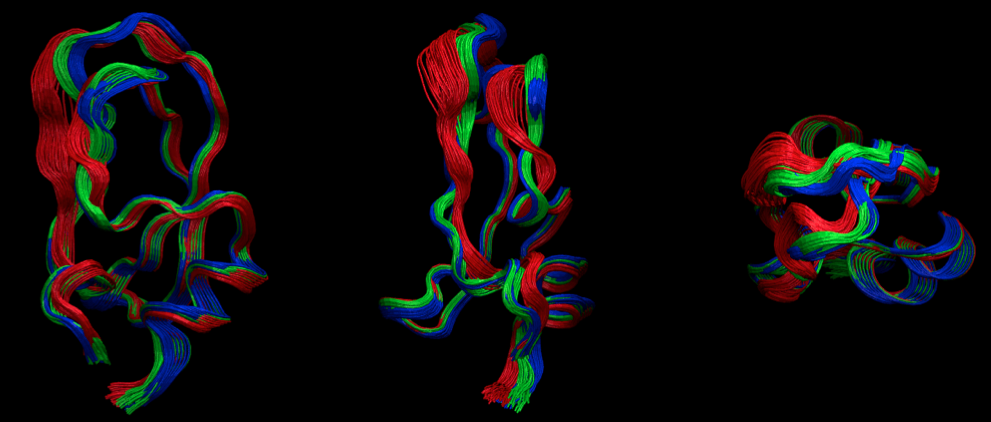

In [43]:
from IPython.display import Image
Image(filename='./data/pcca_structures.png', width=800) 

So you see that the red state is more flexible has a loop folded outward while the other two states are more compact and quite similar. Probably there are more differences in the side-chains, but we don't have the all-atom data here to go further at this point. You get the idea how to do this though...

In order to relate the structures above to the metastable states on our TICA plot, let us (ab)use PCCA to do a crisp clustering, and show the colors correspondingly. We can see that the red state is our single event state on the right hand side:

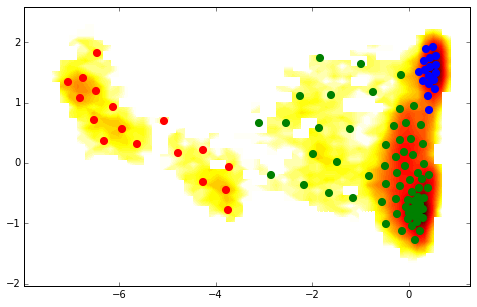

In [44]:
figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=50)
scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=50)
scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='green', s=50)

Experimental observables
-------------

 Now let us play some hypothetical games with experimental observables. We would like to design
 an experiment that allows us to resolve the slowest process in BPTI. By looking at the structures
 we find that the distance between residue 10 - 34 (indexes 9 - 33) exhibits a significant change.
 This is a difference we could measure by a fluorescent probe

Here we use the feature reader to just read this one distance and get it as a vector:

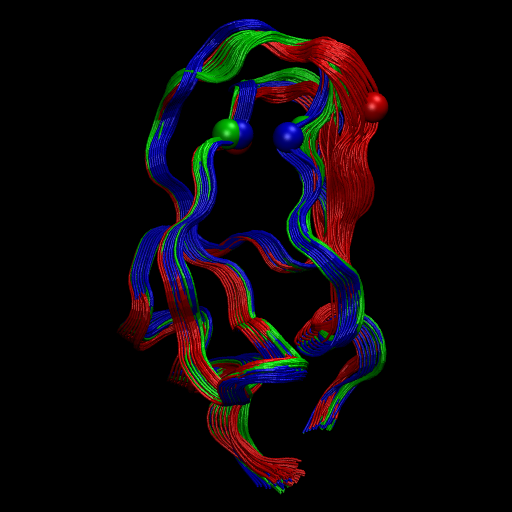

In [45]:
feat2 = coor.featurizer(topfile)
feat2.add_distances(np.array([[9,33]]))
D = coor.load(trajfile, feat2)
Image(filename='./data/observable.png', width=500) 

Let us compare this experimental observable with the slowest TIC...
Not too bad. Much more noisy, but at least there is some correlation.

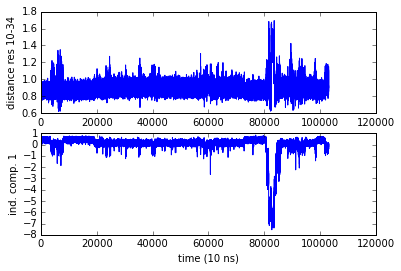

In [46]:
subplot2grid((2,1),(0,0))
plot(D)
ylabel('distance res 10-34')
subplot2grid((2,1),(1,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
xlabel('time (10 ns)')

 You can see that the variations are roughly between 0.8 and 1.5 nanometers. This is actually the perfect distance
 for FRET (although I'm sure that the bulky FRET labels would mess up everything here, but again this is just a 
 hypothetical game). On the other hand they might be close enough to use fluorescence quenching. So one option is 
 to check if there are any trytophanes nearby that can be used as a quencher - that way we could get away with one
 extrinsic fluorophore.

let us average the observable by state:


In [47]:
dmean = shortcuts.average_by_state(dtrajs[0], D, M.nstates)

 plotting the observable on the TICA-map. It's decently correlated with the first TIC, and a good indicator
 of whether we are in the low-populated state.

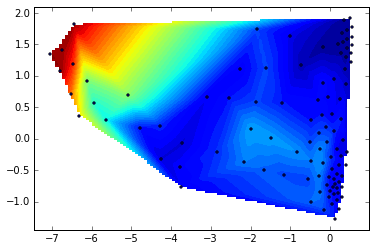

In [48]:
mpl.scatter_contour(cl.clustercenters[:,0], cl.clustercenters[:,1], dmean, colorbar=False)

 this is the ensemble average of our probe distance:

In [49]:
M.expectation(dmean)

0.90942008298074539

 Now let us conduct a correlation experiment. This could be done by using FRET as an observable and then running a
 fluorescence time correlation experiment - very easy to do.

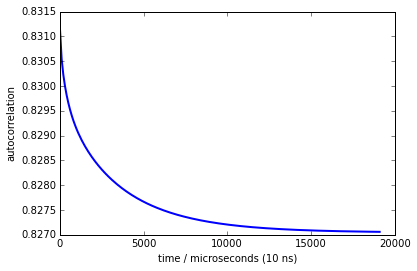

In [50]:
times, corr = M.correlation(dmean)
plot(times, corr, linewidth=2)
xlabel('time / microseconds (10 ns)')
ylabel('autocorrelation')

 We do see a nice decay that contains our slowest timescale.
 Unfortunately, the change in the signal (y-axis) is really small, so that we cannot expect to see anything in
 the presence of experimental errors.
 The problem is that the extra state is too little populated - in an equilibrium measurement such as FCS
 it will have too little contribution, and this is why the amplitude is so small.
 
 We need to find a way to increase the amplitude of the signal. The observable is already pretty good, we can't get
 much better there. But we can do a different experiment that hopefully gives a larger signal: Let us do a 
 perturbation-relaxation experiment. Suppose we would have some way of preparing our ensemble in the low-populated
 state of interest (different temperature, pH, ...?), and then let the system relax towards equilibrium while we
 measure the expectation of the fluorescence.

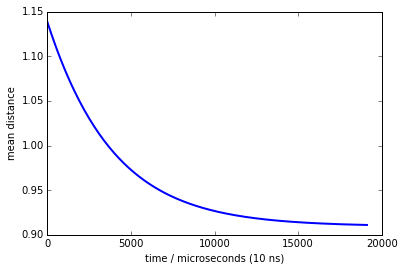

In [51]:
p0 = pcca_dist[0]
times, rel = M.relaxation(p0, dmean)
plot(times, rel, linewidth=2)
xlabel('time / microseconds (10 ns)')
ylabel('mean distance')

 Now we can see a much stronger signal (variation between 0.9 and 1.15) - this will be measurable even with large
 experimental errors.

 This is a very nice and clear observable. If we only could measure whatever we wanted...
 
 now let's plot the relaxation curve in a log-plot.
 And let's add single exponentials with the MSM timescales (showing up as lines), to see if we can match timescales 

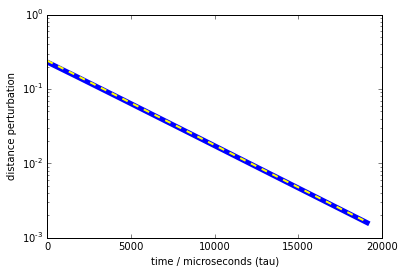

In [52]:
plot(times, rel-M.expectation(dmean), linewidth=5)
t2_tau = M.timescales()[0]
plot(times, 0.24*np.exp(-times / t2_tau), color='yellow', linestyle='dashed', linewidth=2)
semilogy()
xlabel('time / microseconds (tau)')
ylabel('distance perturbation')

 We can nicely see that the main part of the relaxation is exactly due to the slow process. So we have designed an
 experiment that can measure the slow process!
 There are more fast timescales contributing, but their amplitudes are so small that we can hardly see the deviation from a single-exponential. These other timescales could be measured by choosing other coordinates
 
A more systematic analysis could be done using dynamical fingerprints concept described in [6]. Please check the msm functions fingerprint_correlation and fingerprint_relaxation.

Transition pathways and Committors
---------------

Finally, let us compute transition pathways between two selected endstates. This is a very nice mechanistic analysis that is often revealing when we have a two-state process between such as folding or binding. In the present case we would like to know which pathways does the system take to partially unfold into the rarely populated 'right' state. 

At first we have to select what the two end-states of our interest are. We have done PCCA which gives us an idea of metastable sets, but if we do a transition path analysis with three states that's a bit boring, because there are only two options: the single intermediate state is on-pathway or off-pathway. 

We want to get a more detailed analysis. Therefore we reconsider PCCA an this time ask for six metastable sets:

In [53]:
# do pcca with 6 states now
M.pcca(6)
pcca_sets_6 = M.metastable_sets

Which are assigned to the TICA plot as follows:

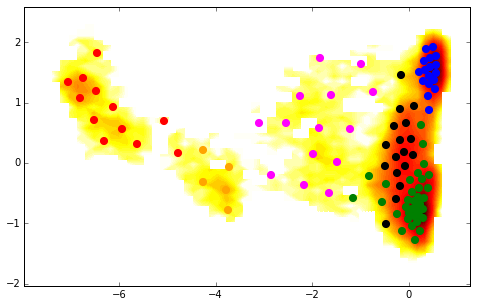

In [54]:
figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
size = 50
cols = ['orange', 'magenta', 'red', 'black', 'blue', 'green',]
for i in range(6):
    scatter(cc_x[pcca_sets_6[i]], cc_y[pcca_sets_6[i]], color=cols[i], s=size)

Now we select as two end-states the leftmost and the rightmost of these 6 sets. Since the ordering of metastable sets could differ in different runs, we actually compute their average positions along the first TICA coordinate:

In [55]:
xavg = shortcuts.avg_by_set(cc_x, pcca_sets_6)
A = pcca_sets_6[xavg.argmax()]
B = pcca_sets_6[xavg.argmin()]

Now we compute the transition pathways. This is done by discrete transition path theory [7] in its MSM formulation [8].

In [56]:
fluxAB = msm.tpt(M, A, B)

In [57]:
# mean first passage times in microseconds
print 0.01*M.mfpt(A, B)
print 0.01*M.mfpt(B, A)

1555.07373493
108.926286477


so, it takes about 1.5 milliseconds on average to go into the low-populated "open" state, and about
100 microseconds to switch back.

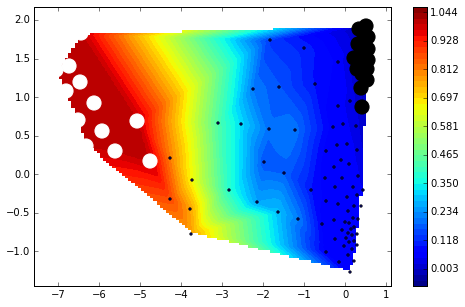

In [58]:
figure(figsize=(8,5))
mpl.scatter_contour(cl.clustercenters[:,0], cl.clustercenters[:,1], fluxAB.committor, colorbar=True, ncontours=15)
scatter(cl.clustercenters[A,0], cl.clustercenters[A,1], color='black', s=200)
scatter(cl.clustercenters[B,0], cl.clustercenters[B,1], color='white', s=200)

In [59]:
cg, cgflux = fluxAB.coarse_grain(pcca_sets)

In [60]:
# compute mean positions of sets. This is important because of some technical points the set order 
# in the coarse-grained TPT object can be different from the input order.
avgpos = np.zeros((6,2))
avgpos[:,0] = shortcuts.avg_by_set(cc_x, cg)
avgpos[:,1] = shortcuts.avg_by_set(cc_y, cg)

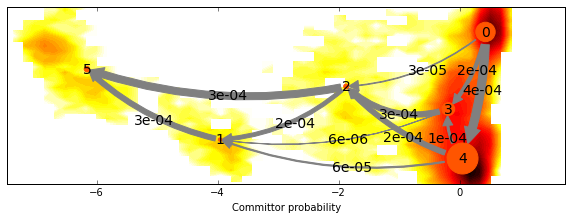

In [61]:
f_size = figure(figsize=(10,5))
cf=contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, fig=f_size,zorder=0)
_ = mpl.plot_flux(cgflux, avgpos, cgflux.stationary_distribution,max_width=10,max_height=7)

This shows us the probability fluxes of pathways from the rightmost state to the leftmost (rare-event) state. You can see that the main pathway leads us to the most stable state, that then splits into two pathways that merge in an intermediate, and then split again before uniting in the target state.

We can decompose the flux into individual pathways, along with their fluxes by:

In [62]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print 'percentage       \tpath'
print '-------------------------------------'
for i in range(len(paths)):
    print (path_fluxes[i] / np.sum(path_fluxes)),' \t', paths[i]

percentage       	path
-------------------------------------
0.403496016708  	[0 4 2 5]
0.271530869238  	[0 3 2 1 5]
0.163205200881  	[0 4 3 2 5]
0.0988653767156  	[0 4 1 5]
0.0389907258549  	[0 2 1 5]
0.0139076038089  	[0 2 5]
0.0100042067934  	[0 4 3 1 5]


We can get a cleaner picture by just plotting the dominant flux, i.e. the flux that only contains the few most important pathways by setting *minflux* to a higher value

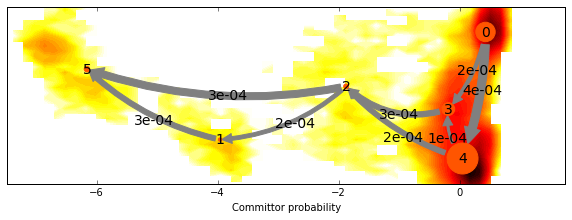

In [63]:
f_size = figure(figsize=(10,5))
cf=contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, fig=f_size,zorder=0)
_ = mpl.plot_flux(cgflux, avgpos, cgflux.stationary_distribution,max_width=10,max_height=5,minflux=1e-04)

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).
3. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
4. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
5. Röblitz S. and M. Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv. Data. Anal. Classif. DOI 10.1007/s11634-013-0134-6 (2013) 
6. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
7. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
8. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)